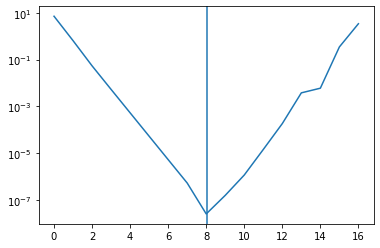

In [9]:
import math
import matplotlib.pyplot as plt
from math import tan, cos

def finite_diff(func, x0, h, true_diff):
    diff_func = (func(x0 + h) - func(x0)) / h
    error = abs(diff_func - true_diff)
    return  error

def center_diff(func, x0, h, true_diff):
    diff_func = (func(x0 + h) - func(x0-h)) / (2*h)
    error = abs(diff_func - true_diff)
    return  error

x0 = 1
func = lambda x: math.tan(x)
true_diff_func = lambda x: 1/ math.cos(x)**2
true_d2_func = lambda x: 2*tan(x)/cos(x)**2
true_d3_func = lambda x: 4*tan(x)**2/cos(x)**2 + 2/cos(x)**4
f1_result = []; f2_result = []
for k in range(17):
    h = 10**(-k)
    f1_result.append(finite_diff(func, x0, h, true_diff_func(x0)))
    f2_result.append(center_diff(func, x0, h, true_diff_func(x0)))



plt.semilogy(range(17), f1_result)
plt.axvline(x = -math.log10(2*math.sqrt(2**(-52) / true_d2_func(x0))))

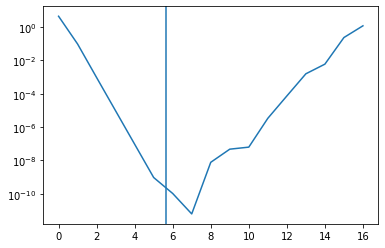

In [18]:
plt.semilogy(range(17), f2_result)
plt.axvline(x = -math.log10((3*2**(-52) / true_d3_func(x0))**(1/3)))

In [21]:
from math import factorial, exp

e_mach = 2**(-52)

def func_exp(x, tol = e_mach):
    ex = 1; k = 0
    truncation_error = tol + 1
    while truncation_error > tol:
        k += 1
        ex += x**k/ factorial(k)
        truncation_error = x**(k+1)/ factorial(k+1)
    return ex


func_exp(1, e_mach)

2.7182818284590455

In [22]:
for x in [1, -1, 5, -5, 10, -10, 15, -15, 20, -20]:
    print(f"x = {x}, build-in exp value = {exp(x)}, func_exp value = {func_exp(x)}")

x = 1, build-in exp value = 2.718281828459045, my program value = 2.7182818284590455
x = -1, build-in exp value = 0.36787944117144233, my program value = 0.5
x = 5, build-in exp value = 148.4131591025766, my program value = 148.41315910257657
x = -5, build-in exp value = 0.006737946999085467, my program value = 8.5
x = 10, build-in exp value = 22026.465794806718, my program value = 22026.46579480671
x = -10, build-in exp value = 4.5399929762484854e-05, my program value = 41.0
x = 15, build-in exp value = 3269017.3724721107, my program value = 3269017.3724721107
x = -15, build-in exp value = 3.059023205018258e-07, my program value = 98.5
x = 20, build-in exp value = 485165195.4097903, my program value = 485165195.40979016
x = -20, build-in exp value = 2.061153622438558e-09, my program value = 181.0


In [23]:
def func_exp2(x0, tol = e_mach):
    x = -x0 if x0 < 0 else x0
    ex = 1; k = 0
    truncation_error = tol + 1
    while truncation_error > tol:
        k += 1
        ex += x**k/ factorial(k)
        truncation_error = x**(k+1)/ factorial(k+1)
    return ex if x0 > 0 else 1/ex

for x in [1, -1, 5, -5, 10, -10, 15, -15, 20, -20]:
    print(f"x = {x}, build-in exp value = {exp(x)}, func_exp2 value = {func_exp2(x)}")

x = 1, build-in exp value = 2.718281828459045, my program value = 2.7182818284590455
x = -1, build-in exp value = 0.36787944117144233, my program value = 0.3678794411714423
x = 5, build-in exp value = 148.4131591025766, my program value = 148.41315910257657
x = -5, build-in exp value = 0.006737946999085467, my program value = 0.006737946999085469
x = 10, build-in exp value = 22026.465794806718, my program value = 22026.46579480671
x = -10, build-in exp value = 4.5399929762484854e-05, my program value = 4.539992976248486e-05
x = 15, build-in exp value = 3269017.3724721107, my program value = 3269017.3724721107
x = -15, build-in exp value = 3.059023205018258e-07, my program value = 3.059023205018258e-07
x = 20, build-in exp value = 485165195.4097903, my program value = 485165195.40979016
x = -20, build-in exp value = 2.061153622438558e-09, my program value = 2.0611536224385583e-09


In [24]:
def func_exp3(x, tol = e_mach):
    ex0 = 1; ex1 = x; k = 0
    truncation_error = tol + 1
    while truncation_error > tol:
        k += 2
        ex0 += x**k/ factorial(k)
        ex1 += x**(k+1)/ factorial(k+1)
        truncation_error = x**(k+2)/ factorial(k+2)
    return ex0 + ex1

for x in [1, -1, 5, -5, 10, -10, 15, -15, 20, -20]:
    print(f"x = {x}, build-in exp value = {exp(x)}, func_exp3 value = {func_exp3(x)}")

x = 1, build-in exp value = 2.718281828459045, my program value = 2.7182818284590455
x = -1, build-in exp value = 0.36787944117144233, my program value = 0.3678794411714421
x = 5, build-in exp value = 148.4131591025766, my program value = 148.4131591025766
x = -5, build-in exp value = 0.006737946999085467, my program value = 0.006737946999095357
x = 10, build-in exp value = 22026.465794806718, my program value = 22026.465794806718
x = -10, build-in exp value = 4.5399929762484854e-05, my program value = 4.539992551144678e-05
x = 15, build-in exp value = 3269017.3724721107, my program value = 3269017.37247211
x = -15, build-in exp value = 3.059023205018258e-07, my program value = 3.059394657611847e-07
x = 20, build-in exp value = 485165195.4097903, my program value = 485165195.4097903
x = -20, build-in exp value = 2.061153622438558e-09, my program value = 5.960464477539063e-08


In [29]:
import numpy as np
import time

timecost_eig = []; timecost_solve = []; timecost_inv = []

for n in [500, 1000, 2000, 4000, 8000]:
    B = np.random.randn(n,n)
    b = np.random.randn(n,1)
    A = B.T @ B
    t0 = time.time()
    np.linalg.eig(A)
    t1 = time.time()
    print(f"At n = {n}, eig function cost time {t1 - t0} s")
    timecost_eig.append(t1 - t0)
    x = np.linalg.solve(A, b)
    t2 = time.time()
    print(f"At n = {n}, x = A/b cost time {t2 - t1} s")
    timecost_solve.append(t2 - t1)
    x = np.linalg.inv(A) @ b
    t3 = time.time()
    print(f"At n = {n}, x = inv(A)*b cost time {t3 - t2} s")
    timecost_inv.append(t3 - t2)


At n = 500, eig function cost time 0.1676042079925537 s
At n = 500, x = A/b cost time 0.00976109504699707 s
At n = 500, x = inv(A)*b cost time 0.00595545768737793 s
At n = 1000, eig function cost time 0.8349676132202148 s
At n = 1000, x = A/b cost time 0.015119314193725586 s
At n = 1000, x = inv(A)*b cost time 0.05575895309448242 s
At n = 2000, eig function cost time 5.319272994995117 s
At n = 2000, x = A/b cost time 0.07953047752380371 s
At n = 2000, x = inv(A)*b cost time 0.2858569622039795 s
At n = 4000, eig function cost time 33.819058418273926 s
At n = 4000, x = A/b cost time 0.5434150695800781 s
At n = 4000, x = inv(A)*b cost time 2.135286808013916 s
At n = 8000, eig function cost time 267.15941071510315 s
At n = 8000, x = A/b cost time 5.191667795181274 s
At n = 8000, x = inv(A)*b cost time 16.09119176864624 s


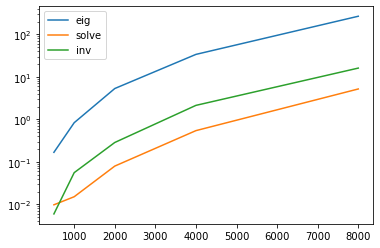

In [30]:
plt.semilogy([500, 1000, 2000, 4000, 8000], timecost_eig, label = 'eig')
plt.semilogy([500, 1000, 2000, 4000, 8000], timecost_solve, label = 'solve')
plt.semilogy([500, 1000, 2000, 4000, 8000], timecost_inv, label = 'inv')
plt.legend()
plt.show()

In [32]:
import json
dict1 = {'eig': timecost_eig, 'solve': timecost_solve, "inv": timecost_inv}

info_json = json.dumps(dict1, sort_keys=False, indent=4, separators=(',', ': '))

f = open('info.json', 'w')
f.write(info_json)
f.close()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("info.json", 'r') as jfile:
    dict1 = json.load(jfile)

The scaling coefficient of eig is ~ 10^(0.0003938262413626475 * time -0.45531358483066386)
The scaling coefficient of solve is ~ 10^(0.00036361079958524827 * time -2.0231929193692584)
The scaling coefficient of inv is ~ 10^(0.00040927390106778395 * time -1.7660645020735226)


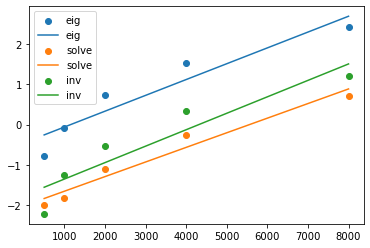

In [18]:
from scipy.stats import linregress
# from IPython.display import Latex

nlist = [500, 1000, 2000, 4000, 8000]
for keys in dict1.keys():
    value = np.log10(np.array(dict1[keys]))
    slope, intercept, r_value, p_value, std_err = linregress(x = nlist, y = value)
    print(f"The scaling coefficient of {keys} is ~ 10^({slope} * time {intercept})")
    predict = intercept + slope * np.array(nlist)
    plt.scatter(nlist, value, label = keys)
    plt.plot(nlist, predict, label = keys)
    plt.legend()
plt.show()
